In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv('../data/final_data.csv')

In [3]:
df

,date,payment,site,item_name,brand_name,group0,group1,category,gender,age,color,size,total_revenue
0,2019-06-01,COD,tint-store.cz,Adidas Originals bucket hat hut,adidas Originals,Apparel,Caps,lifestyle,unisex,adults,Black,OSFM,20.789147
1,2019-06-01,COD,11teamsports.cz,LS GARDIEN JSY,Nike,Apparel,T-Shirts,football,men,adults,Green,XXL,34.403101
2,2019-06-01,COD,top4running.cz,W NK RUN TOP SS,Nike,Apparel,T-Shirts,running,women,adults,White,XS,10.378682
3,2019-06-01,PAYPAL,top4fitness.de,NK ELMNTL BKPK,Nike,Equipment,Backpacks,football,unisex,adults,Green,ks,8.245429
4,2019-06-01,COD,top4running.ro,NIKE ZOOM RIVAL S 9,Nike,Footwear,Running shoes,running,unisex,adults,Black,42,106.351023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128519,2022-01-14,COD,11teamsports.cz,Dopravné,- žádný výrobce -,Other,Running shoes,football,men,adults,Black,M,1.889922
2128520,2022-01-14,COD,top4running.hu,Nike Womens Kiger Vest 40,Nike,Equipment,Backpacks,running,women,adults,Silver,XS/S,93.929085
2128521,2022-01-14,COD,11teamsports.cz,Platba,- žádný výrobce -,Other,Running shoes,football,men,adults,Black,M,0.929070
2128522,2022-01-14,COD,11teamsports.cz,adidas Mundial Goal IN,adidas,Footwear,Football shoes,football,men,adults,Black,"37,3",94.400775


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
daily_sales = pd.DataFrame(df.groupby('date')['total_revenue'].sum().resample('d').sum())

In [6]:
daily_sales

,total_revenue
date,
2019-06-01,4121.074856
2019-06-02,78.764024
2019-06-03,1354.000653
2019-06-04,70505.743012
2019-06-05,66236.436269
...,...
2022-01-10,109472.937561
2022-01-11,112798.634218
2022-01-12,102618.516796


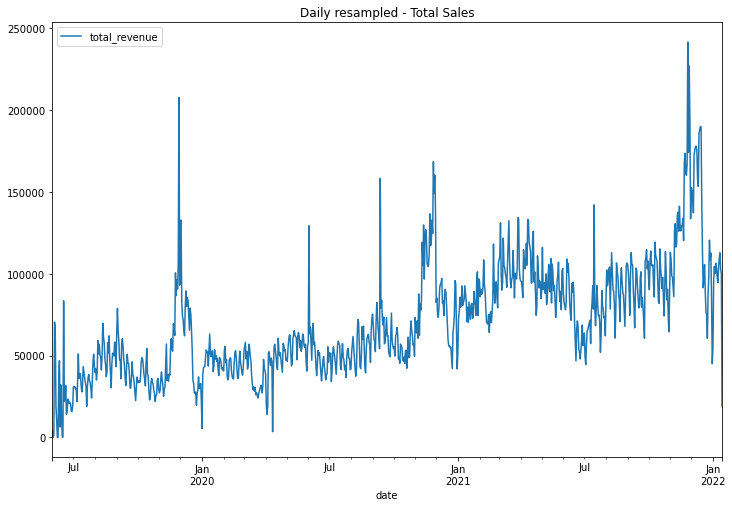

In [7]:
plt.rcParams["figure.figsize"] = (12, 8)
daily_sales.plot()
plt.title('Daily resampled - Total Sales')
plt.show()

In [8]:
daily_sales.index = pd.to_datetime(daily_sales.index)

In [9]:
# Check for stationery 

from statsmodels.tsa.stattools import adfuller

X = daily_sales.total_revenue
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

    
    


ADF Statistic: -3.320330
p-value: 0.013994
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [10]:
new_daily_sales = daily_sales.drop(columns='total_revenue')

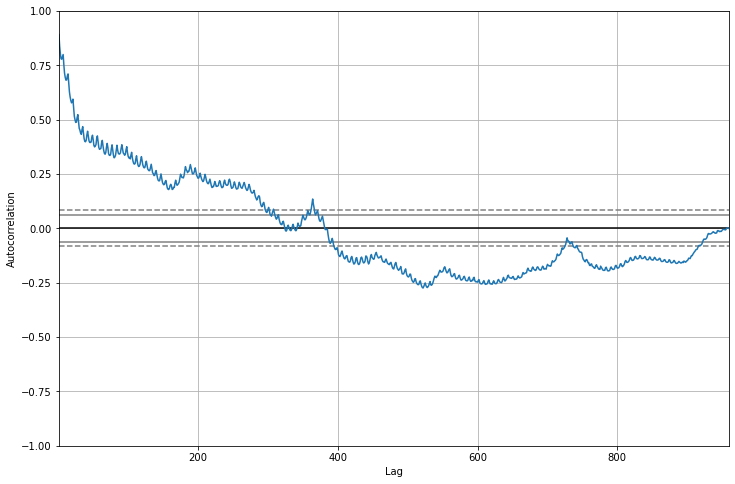

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(X)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


model = ARIMA(X, order=(16,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                  959
Model:                ARIMA(16, 0, 0)   Log Likelihood              -10469.421
Date:                Sun, 20 Feb 2022   AIC                          20974.842
Time:                        17:51:18   BIC                          21062.428
Sample:                    06-01-2019   HQIC                         21008.199
                         - 01-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.991e+04   9385.850      7.449      0.000    5.15e+04    8.83e+04
ar.L1          0.5798      0.017     35.034      0.000       0.547       0.612
ar.L2          0.1517      0.029      5.286      0.0

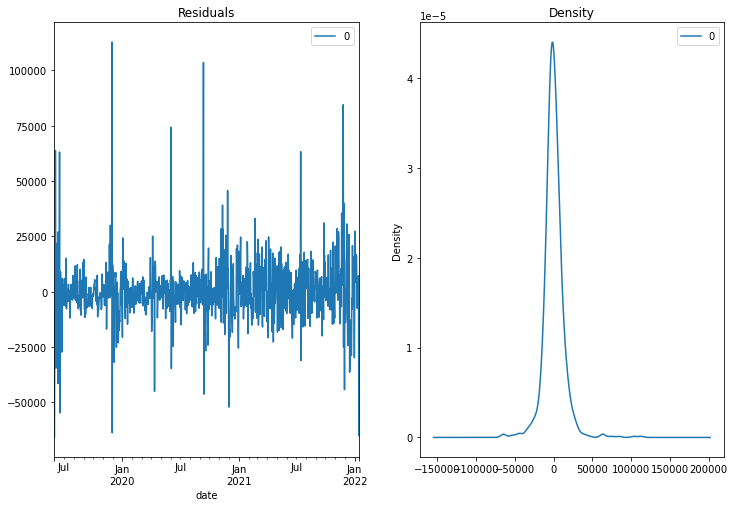

In [13]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [14]:
X = daily_sales.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(16, 0, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)



predicted=96398.373729, expected=95152.011134
predicted=102270.555669, expected=91444.597851
predicted=102376.155569, expected=85401.547130
predicted=89720.547419, expected=114666.322889
predicted=96446.515750, expected=106858.530905
predicted=98466.099472, expected=102903.244679
predicted=99148.304152, expected=105397.395301
predicted=99425.465467, expected=118583.942453
predicted=112949.176929, expected=105266.194100
predicted=109113.814009, expected=133116.082476
predicted=123197.638441, expected=132746.775944
predicted=116734.352281, expected=119054.997906
predicted=114723.958986, expected=116706.102252
predicted=111734.905286, expected=113372.190828
predicted=111103.790933, expected=94184.627902
predicted=99958.694353, expected=94438.906187
predicted=103899.342218, expected=120811.516383
predicted=115820.125771, expected=125938.209492
predicted=117026.049452, expected=94953.548560
predicted=101113.894160, expected=101034.759430
predicted=98673.078108, expected=89386.418412
predict

predicted=77357.089295, expected=107731.283508
predicted=99080.585766, expected=109485.928343
predicted=95657.587816, expected=114656.507661
predicted=102422.489729, expected=103006.594510
predicted=93199.340057, expected=107632.435413
predicted=94910.422743, expected=96132.111120
predicted=94306.116869, expected=90207.479347
predicted=105176.666811, expected=107905.011071
predicted=107750.234619, expected=113899.924620
predicted=105988.427418, expected=105017.265483
predicted=100756.744126, expected=104846.045057
predicted=98229.306055, expected=105365.662449
predicted=94072.582113, expected=92801.338084
predicted=93361.076405, expected=85791.846252
predicted=101863.796888, expected=119342.572239
predicted=114687.435472, expected=111368.219712
predicted=107500.159975, expected=109491.161782
predicted=106632.850229, expected=107718.798581
predicted=102210.428079, expected=95081.699989
predicted=91486.315781, expected=83055.629719
predicted=87340.262706, expected=81886.799615
predicted=

In [15]:
len(test), len(predictions)

(288, 288)

In [16]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14914.401


In [17]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



mape=mean_absolute_percentage_error(test, predictions)
print('MAPE: ', mape)

MAPE:  32.14418952536031


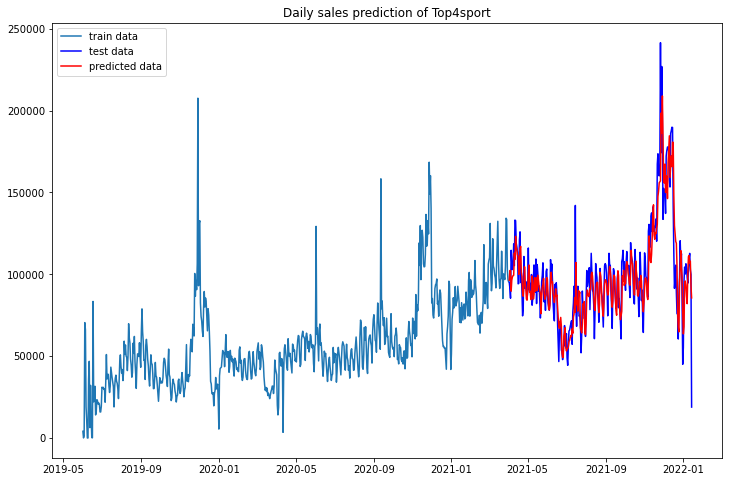

In [18]:
# plot forecasts against actual outcomes

plt.plot(daily_sales[:size].index, train, label='train data')
plt.plot(daily_sales[size:].index, test, color='blue', label='test data')
plt.plot(daily_sales[size:].index, predictions, color='red', label='predicted data')
plt.legend(loc="upper left")
plt.title('Daily sales prediction of Top4sport')
plt.show()

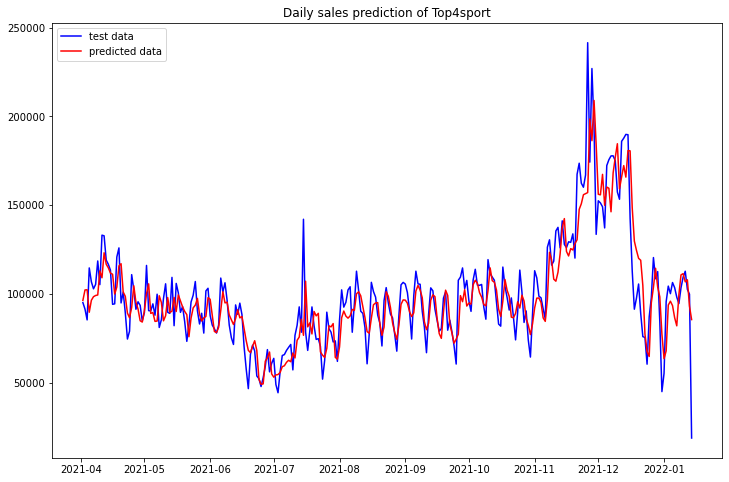

In [19]:
# plot forecasts against actual outcomes   # Zoomed for test data

# plt.plot(daily_sales[:size].index, train, label='train data')
plt.plot(daily_sales[size:].index, test, color='blue', label='test data')
plt.plot(daily_sales[size:].index, predictions, color='red', label='predicted data')
plt.legend(loc="upper left")
plt.title('Daily sales prediction of Top4sport')
plt.show()

In [20]:
forecast = model_fit.forecast(steps=30)


day=1
for yhat in forecast:
    print('day {}: {}'.format(day,yhat))
    day = day + 1

day 1: 85589.78726104953
day 2: 87461.33134814707
day 3: 100150.24078241643
day 4: 103980.50532424187
day 5: 103267.72250828767
day 6: 100971.37524944435
day 7: 97139.24063493893
day 8: 90939.44871491173
day 9: 91176.7807854791
day 10: 97113.545374027
day 11: 100337.08496863795
day 12: 100075.37198073199
day 13: 96693.03951146669
day 14: 92398.75391374236
day 15: 87581.14981669078
day 16: 88404.34488801827
day 17: 93582.35968858072
day 18: 95835.1825777927
day 19: 95275.15244349238
day 20: 93158.08264358279
day 21: 89839.53748675362
day 22: 86811.5796623827
day 23: 87454.01566370566
day 24: 90678.52763892338
day 25: 92353.16330128333
day 26: 91872.74697119248
day 27: 89874.08433749457
day 28: 87050.7759167928
day 29: 84936.09525304359
day 30: 85609.1055309741


In [21]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 14914.401


In [ ]:
# Hypertuning the parameters

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
    
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
        
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

In [ ]:
# evaluate parameters
p_values = [10, 15 , 16, 20]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(daily_sales.values, p_values, d_values, q_values)
